# IE 643: Feed Forward Net (Multi-Layered Perceptron) Demo

In this demo, we will learn how to build a Multi-layered Perceptron (Feed Forward Nerual Network) model from scratch. There are a lot of libraries available like Pytorch, Keras, Tensorflow etc. which can help you build much complex models in much fewer lines. However before using them, it is important to understand how to build your own neural network from scratch. 

In [85]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

## **Data loading and pre-processing**

We will be using the MNIST dataset for classification. It contains grayscale images of handwritten digits(0-9) in 28x28 size. Our task is to build a neural network to classify these images. 

> The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

Source: http://yann.lecun.com/exdb/mnist/

## Loading the dataset:

In [86]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(f'Train: X - {X_train.shape}, y - {Y_train.shape}')
print(f'Test: X - {X_test.shape}, y - {Y_test.shape}')

Train: X - (60000, 28, 28), y - (60000,)
Test: X - (10000, 28, 28), y - (10000,)


In [87]:
unique, counts = np.unique(Y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


#### Displaying an image from the dataset

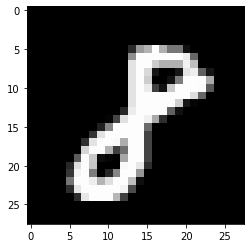



Label in dataset: 8


In [88]:
plt.imshow(X_train[31],cmap='gray')
plt.show()
print(f"\n\nLabel in dataset: {Y_train[31]}")

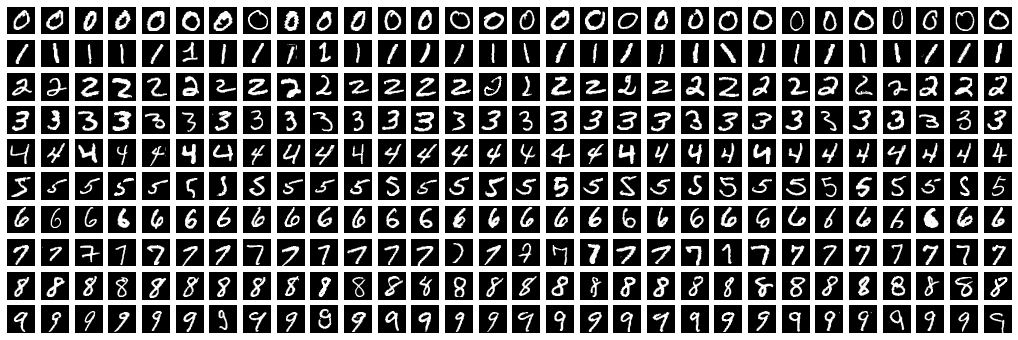

In [89]:
# Sample images for all digits

digits = np.unique(Y_train)
M = 30
dim = 28
fig, axs = plt.subplots(len(digits), M, figsize=(18,6))

for i,d in enumerate(digits):
    for j in range(M):
        axs[i,j].imshow(X_train[Y_train==d][j].reshape((dim,dim)), cmap='gray')
        axs[i,j].axis('off')

In [90]:
X_train[31]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         42, 154, 180, 255, 176, 118, 118,  16,   0,   0,   0,   0,   0,
          0,   0],
       [  

As you can see here, each image is a (28x28) 2d numpy array and hence contains 784 individual pixel values (in grayscale).

In [91]:
# flattening single example 
example = X_train[31].reshape((-1))
print(type(example))
print("Shape:", example.shape)

<class 'numpy.ndarray'>
Shape: (784,)


##Pre-processing:

**Flattening the input values:**
Since we are using a simple Feed-forward Nerual Network, it's better to convert each input from a 2D array to a 1D array. This process is called flattening. 

In [92]:
# flattening the input

X_train_flattened = X_train.reshape((X_train.shape[0], -1))
X_test_flattened = X_test.reshape((X_test.shape[0], -1))

print(f"Shapes - Train: {X_train_flattened.shape}, Test: {X_test_flattened.shape}")

Shapes - Train: (60000, 784), Test: (10000, 784)


**Normalizing input values:**

We often need to normalize the input values into a convinient range. Let us see what is the current range of pixel values:

In [93]:
print("Minimum pixel value =", X_train_flattened.min())
print("Maximum pixel value =", X_train_flattened.max())

Minimum pixel value = 0
Maximum pixel value = 255


So it turns out that the pixel values are in the standard grayscale range **0-255** (in some datasets it can differ. For e.g., in the 'digits' dataset, the range is 0-16)

We want to normalize the input such that each value lies in the (0,1) range. Hence we will divide each of the input values by 255. This will not affect the nature of input.

**Normalizing the dataset:** 

In [94]:
X_normalized_train = np.round(X_train_flattened/255, 3)
X_normalized_test = np.round(X_test_flattened/255, 3)

print("Minimum pixel value =", X_normalized_train.min())
print("Maximum pixel value =", X_normalized_train.max())

Minimum pixel value = 0.0
Maximum pixel value = 1.0


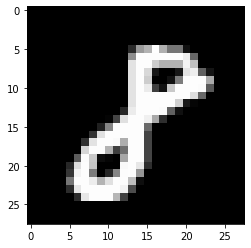

In [95]:
# normalized and flattened data can still be visualized as original data
plt.imshow(X_normalized_train[31].reshape(28,28), cmap='gray')
plt.show()

As you can see, normalizing doesn't affect the nature of image. It all depends on the relative values. So now we will use this flattened input layer and proceed for the next step.

## Creating datasets for binary and multi-class Classification:

We will have a look at two problems. First one is binary classification, whereas second one is a multiclass classification problem.

### **Binary Classification problem:**

MNIST has 10 different target classes, each representing one of the digits from 0-9. Let's consider digit '**0**' and digit '**6**'. Let's extract these inputs from the original dataset.

**Creating the subsets:**

In [96]:
train_idx = np.where((Y_train==0) | (Y_train==6))
X_train_bin = X_normalized_train[train_idx]
Y_train_bin = Y_train[train_idx]

test_idx = np.where((Y_test==0) | (Y_test==6))
X_test_bin = X_normalized_test[test_idx]
Y_test_bin = Y_test[test_idx]

print(f'Trainset shapes - X: {X_train_bin.shape}, Y: {Y_train_bin.shape}')
print(f'Testset shapes - X: {X_test_bin.shape}, Y: {Y_test_bin.shape}')

print(f'\nTrain statistics - 0: {(Y_train_bin==0).sum()}, 6: {(Y_train_bin==6).sum()}')
print(f'Test statistics - 0: {(Y_test_bin==0).sum()}, 6: {(Y_test_bin==6).sum()}')

Trainset shapes - X: (11841, 784), Y: (11841,)
Testset shapes - X: (1938, 784), Y: (1938,)

Train statistics - 0: 5923, 6: 5918
Test statistics - 0: 980, 6: 958


In [97]:
# Setting label of class 6 to 1 for binary classification problem

Y_train_bin[Y_train_bin==6] = 1 
Y_test_bin[Y_test_bin==6] = 1 

We now have only 0s and 6s in the newly created subsets. Also number of 0s and 6s is quite even. So we can say that the dataset is quite evenly balanced. In practical situations, often it's the opposite and we need to implement different techniques to balance it. 

**Splitting the training dataset:**

Often it is observed that training the model for a large number of epochs leads to overfitting. To avoid this problem, we need a validation dataset to keep track of the 'validation accuracy'. Hence now we will split the current training dataset (of 11841 instances) into a training set and a validation set.

In [98]:
from sklearn.model_selection import train_test_split

(Even though the function name says train_test_split, you can use it for validation dataset or any kind of split in general)

We are splitting the old training dataset here. In practice, people consider splits like 90-10, 80-20, 67-33 etc. You can chose your own value. It's always a tradeoff. If validation dataset is too small, it may not reflect the best results in terms of validation accuracy. On the other hand, taking a large chunk for validation part may result in loss of some info while training.

We will go with 80-20 spllit for now.

In [99]:
X_train_bin, X_val_bin, Y_train_bin, Y_val_bin = train_test_split(X_train_bin, Y_train_bin, test_size=0.2, random_state = 1)

In [100]:
print("Instances in new train-set:", len(Y_train_bin))
print("Instances in val-set:", len(Y_val_bin))
print("\nCount of 0s and 6s in train-set:", (Y_train_bin==0).sum(), (Y_train_bin==1).sum())
print("Count of 0s and 6s in val-set:", (Y_val_bin==0).sum(), (Y_val_bin==1).sum())

Instances in new train-set: 9472
Instances in val-set: 2369

Count of 0s and 6s in train-set: 4724 4748
Count of 0s and 6s in val-set: 1199 1170


In [101]:
# Traspose feature matrices as per our model requirement

X_train_bin, X_val_bin, X_test_bin = X_train_bin.T, X_val_bin.T, X_test_bin.T
print(f'Shapes - {X_train_bin.shape, X_val_bin.shape, X_test_bin.shape}')

Shapes - ((784, 9472), (784, 2369), (784, 1938))


It's important to know that the split function has an argument **shuffle** which is **True** by default. It means that your data is shuffled before splitting. If you are using a custom method to split, keep this in mind!

Also we are using a **random_state** parameter to ensure the same split at each run. It's not necessary to use in practice unless you want to do experiments with the same split.

Let's get to our model:


## Building the Neural Net class: 

In [102]:
def get_lr(lr):
    if isinstance(lr, (float, int)): # constant lr arg is passed to train
        return lambda x: lr # we return a function object which returns the same lr at every epoch
    elif callable(lr): # function lr arg is passed to train
        return lr # the function is then used to get lr for a particular epoch
    else:
        raise ValueError('param lr can only be a number or a scheduler function')
    
print(get_lr(1e-3)(5))

0.001


In [113]:
class Neural_Network():
    def __init__(self, neurons, Activations, initialization='randn'):
        """Define the NN design parameters
        Args:
            neurons (int array): list of numbers listing neurons for each layer
            Activations (str array): list of activations to be used for hidden and output layers
            initialization (str, optional): Choose weight initialization from
            uniform or normal distribution. Defaults to 'randn'.
        """
        
        self.inputSize = neurons[0] # Number of neurons in input layer
        self.outputSize = neurons[-1] # Number of neurons in output layer
        self.layers = len(neurons)
        self.weights = [] # weights for each layer
        self.biases = [] # biases in each layer 
        self.layer_activations = [] # activations in each layer
        # self.loss = self.lossSE
        if initialization == 'rand':
            self.initializer = np.random.rand
        elif initialization == 'randn':
            self.initializer = np.random.randn
        else:
            raise ValueError("initialization must be 'rand' or 'randn'")
        for i in range(len(neurons)-1):
            self.weights.append(self.initializer(neurons[i+1],neurons[i])) # weight matrix between layer i and layer i+1
            self.biases.append(self.initializer(neurons[i+1],1))
            self.layer_activations.append(Activations[i]) # activations for each layer
        
            
    def sigmoid(self, z):
        """returns result of the sigmoid activation function on input z."""                 
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoidPrime(self,z):
        """returns derivative of sigmoid activation function applied on input z."""
        return self.sigmoid(z)*(1-self.sigmoid(z))

    def tanh(self, z):
        """returns result of the hyperbolic tan activation function on input z."""
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

    def tanhPrime(self, z):
        """returns derivative of hyperbolic tan activation function applied on input z."""
        return 1 - self.tanh(z)**2

    def linear(self, z):
        """returns result of the linear activation function on input z."""
        return z

    def linearPrime(self, z):
        """returns derivative of linear activation function applied on input z."""
        return 1

    def ReLU(self, z):
        """returns result of the ReLU activation function on input z."""
        return np.maximum(0, z)

    def ReLUPrime(self, z):
        """returns derivative of ReLU activation function applied on input z."""
        return z > 0
    
    def softmax(self, z):
        """returns result of the softmax activation function on input z."""
        return np.exp(z) / np.sum(np.exp(z), axis=0)
    
    def lossSE(self, predicted, actual):
        """Implementation of Squared-error loss function."""
        return np.mean(0.5*(predicted-actual)**2)
    
    def lossCE(self, predicted, actual):
        """Implementation of Cross-Entropy loss function."""
        return (-1 / actual.shape[1]) * np.sum(np.multiply(actual, np.log(predicted)))
    
    def forward(self, a):
        """Defines forward pass of the NN

        Args:
            a (array): input of size self.inputSize

        Returns:
            a (array): output of the forward pass
            layer_dot_prod_z (list): layerwise intermediate outputs
            layer_activations_a (list): layerwise activations
        """

        layer_activations_a = [a] # store the input as the input layer activations
        layer_dot_prod_z = []
        for i, param in enumerate(zip(self.biases, self.weights)):
            b, w = param[0], param[1]
            z = np.dot(w, a)+b
            if self.layer_activations[i].lower()=='sigmoid':
                a = self.sigmoid(z)
            elif self.layer_activations[i].lower()=='relu':
                a = self.ReLU(z)
            elif self.layer_activations[i].lower()=='tanh':   
                a = self.tanh(z)
            elif self.layer_activations[i].lower()=='linear':
                a = self.linear(z)
            elif self.layer_activations[i].lower()=='softmax':
                a = self.softmax(z)
            else:
                raise ValueError("Activation function not supported")
            layer_dot_prod_z.append(z)
            layer_activations_a.append(a)
        return a, layer_dot_prod_z, layer_activations_a

    def backward(self, x, y, zs, activations):
        """backward pass to calculate gradient of loss w.r.t. NN parameters

        Args:
            x (array): input
            y (array): ouputs from forward pass
            zs (list): layerwise intermediate outputs from forward pass
            activations (list): layerwise activations from forward pass

        Returns:
            gradients (tuple): gradients with respect to bias and weight parameters respectively
        """
        
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        n = zs[-1].shape[1]
        
        for t in range(1, len(activations)):
            if t == 1:
                delta = (activations[-t] - y)
            else:
                delta = np.dot(self.weights[-t+1].transpose(), delta)

            if self.layer_activations[-t].lower()=='sigmoid':
                delta *= self.sigmoidPrime(zs[-t])
            elif self.layer_activations[-t].lower()=='relu':
                delta *= self.ReLUPrime(zs[-t])
            elif self.layer_activations[-t].lower()=='tanh':   
                delta *= self.tanhPrime(zs[-t])
            elif self.layer_activations[-t].lower()=='linear':
                delta *= self.linearPrime(zs[-t])
            # elif self.layer_activations[t].lower()=='softmax':
            #     delta *= self.softmaxPrime(zs[-t])
            else:
                raise ValueError("Activation function not supported")

            grad_b[-t] = np.sum(delta, axis=1, keepdims=True) / n
            grad_w[-t] = np.dot(delta, activations[-t-1].transpose()) / n

        return (grad_b, grad_w)                 


    def update_parameters(self, grads, lr):
        """update the NN parameters using the gradients

        Args:
            grads (list): gradients obtained from backward pass
            lr (float): learning rate of NN
        """
        
        grad_b, grad_w = grads[0], grads[1]

        for i in range(len(self.weights)):
            self.weights[i] -= lr * grad_w[i]
            self.biases[i] -= lr * grad_b[i]


    def error(self, X, Y, errors):  
        """Appends loss to error list"""
        y = np.squeeze(self.forward(X)[0])
        errors.append(self.loss(y, Y))

    def copy_params(self):
        """Returns a copy of current NN parameters"""
        weights = [w.copy() for w in self.weights]
        biases = [b.copy() for b in self.biases]
        return (weights, biases)

    def train(self, X, Y, lr = 1e-3, max_epochs = 1000, patience=5, batch_size = None,
            n_classes=10, onehotencoded=False, loss_func='SE', Xval=None, Yval=None, verbose=True):
        """Function for training our Neural Network

        Args:
            X (ndarray): feature matrix of training data,
            Shape: (n,m) where n is no. of features and m is no. of samples.
            Y (ndarray): ground truth of training data, NOT one-hot-encoded. Shape: (1,m).
            lr (float or function, optional): constant learning rate or scheduler function.
            Defaults to 1e-3 constant lr.
            max_epochs (int, optional): epoch cap for training. Defaults to 1000.
            patience (int, optional): patience parameter for early stopping. Defaults to 5.
            batch_size (int, optional): mini-batch size. Defaults to full-batch GD if not provided.
            n_classes (int, optional): no. of classes for multi-class classification required if
            one-hot encoding is set to True. Defaults to 10.
            onehotencoded (bool, optional): Defaults to False.
            loss_func (str, optional): Choose from 'SE' and 'CE' loss functions. Defaults to 'SE'.
            Xval (ndarray, optional): Validation data feature matrix. Defaults to None.
            Yval (ndarray, optional): Validation data ground truth. Defaults to None.
            verbose (bool, optional): If True, displays logs and progress of training. Defaults to True.

        Returns:
            [list/tuple]: lists of train-set and validation-set losses seen over the traning process.
        """
        
        if onehotencoded:
            # a method for creating one hot encoded labels 
            def onehotencoding(Y, n):
                # one-hot encoding of class i is just the ith column of the identity 
                # matrix of size n where n is the total number of classes. so below 
                # code uses Y (a 1d array) for indexing into the identity matrix.
                raise NotImplementedError 

            Y = onehotencoding(Y, n_classes)
            if Yval is not None:
                Yval = onehotencoding(Yval, n_classes)

        # Below code ensures that Y is 2-dimensional even when one-hot encoding is not
        # performed, so our same code works for training NN for both tasks.  
        Y = np.expand_dims(Y,0) if len(Y.shape) == 1 else Y
        Yval = np.expand_dims(Yval,0) if (Yval is not None and len(Yval.shape) == 1) else Yval
        
        if loss_func == 'SE':
            self.loss = self.lossSE
        elif loss_func == 'CE':
            self.loss = self.lossCE
            
        train_errors=[]
        if Xval is not None:
            val_errors=[]
        i, j, v = 0, 0, np.inf
        best_params = self.copy_params()
        
        if batch_size is not None:
            if batch_size > len(X[0]):
                raise ValueError("invalid mini-batch size. Must be smaller than dataset length")
        else:
            batch_size = len(X[0])
            
        
        while j < patience:

            # Shuffle Dataset
            idx = np.arange(len(X[0]))
            np.random.shuffle(idx)
            X1 = np.take(X,idx,axis=-1) 
            Y1 = np.take(Y,idx,axis=-1)

            for q in range(0,len(X1[0]),batch_size):
                start, end = q, min(len(X1[0]), q+batch_size)
                train_x = X1[:, start:end] 
                train_y = Y1[:,start:end]
                out, dot_prod_z, activations_a = self.forward(train_x)
                grads = self.backward(train_x, train_y, dot_prod_z, activations_a) # find the gradients using backward pass
                self.update_parameters(grads, lr)
                # self.update_parameters(grads, i)
            i += 1 # increment epoch count

            self.error(X, Y, train_errors)
            if Xval is not None:
                self.error(Xval, Yval, val_errors)

                if val_errors[-1] < v:
                    j = 0 # reset patience counter
                    v = val_errors[-1] # update best loss
                    best_params = self.copy_params() # save params
                else:
                    j += 1 # increment patience counter

            if verbose and i%5 == 0:
                log = f"Epoch {i}..............Loss on train = {train_errors[-1]}"
                if Xval is not None:
                    log += f", Loss on val = {val_errors[-1]}"
                print(log)
                
            if i >= max_epochs:
                break # stop if epoch threshold crossed

        if Xval is not None:
            if i >= max_epochs and verbose:
                print("Reached Epoch Cap without convergence....Terminating")
            elif verbose:
                print("Early Stopping .............. Returning best weights")

            self.weights, self.biases = best_params # reset to best params
                    
        if verbose:
            x = np.arange(1, len(train_errors)+1)
            plt.plot(x, train_errors, label="Loss on Train")
            if Xval is not None:
                plt.plot(x, val_errors, label="Loss on Val")
            plt.legend()
            plt.title(f"{loss_func} - Learning Rate = {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        if Xval is not None:           
            return (train_errors, val_errors)
        return train_errors
        
    def predict(self, x):
        #Implement the code for prediction
        out, dot_prod_z, activations_a = self.forward(x)
        return out > 0.5


**Creating a MLP (Feed forward NN) model instance for our Binary classification task :**

Let's now create a simple feed-forward neural network. 

* Number of input neurons = 784.
* Number of output layer neurons = 1.

The number of hidden layers and number of neurons in each hidden layer can be decided by the user.

In [115]:
#D_in is input dimension
#H1 is dimension of first hidden layer 
#H2 is dimension of second hidden layer
#D_out is output dimension.

D_in, H1, H2, D_out = 784, 200, 100, 1 #You can add more layers or more outputs if you wish. 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['sigmoid','sigmoid','sigmoid'] # activations in each layer (Note: the input layer does not have any activation)
nn_bin = Neural_Network(neurons, activation_functions) # There we go, creating our neural network.

### Training the model:

Epoch 5..............Loss on train = 0.03542740306080495, Loss on val = 0.035758461519662395
Epoch 10..............Loss on train = 0.020931066209842687, Loss on val = 0.023414402008158215
Epoch 15..............Loss on train = 0.015776885159354073, Loss on val = 0.019067763518223035
Epoch 20..............Loss on train = 0.013037249925008815, Loss on val = 0.016784484431677838
Epoch 25..............Loss on train = 0.011256301619184821, Loss on val = 0.015244969126194293
Epoch 30..............Loss on train = 0.010036152334813815, Loss on val = 0.014106295880859494
Epoch 35..............Loss on train = 0.009148156634585063, Loss on val = 0.013239475665325752
Epoch 40..............Loss on train = 0.008467012966872862, Loss on val = 0.012531656471201911
Epoch 45..............Loss on train = 0.007918025469762334, Loss on val = 0.011945940353646522
Epoch 50..............Loss on train = 0.007461977898735282, Loss on val = 0.01145209562591976
Epoch 55..............Loss on train = 0.0070710063657

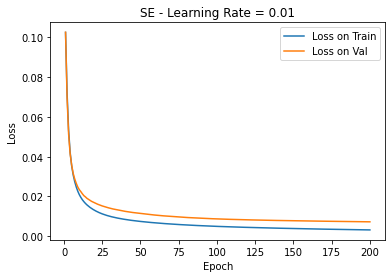

In [111]:
losses = nn_bin.train(X_train_bin, Y_train_bin, batch_size=10, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

### Testing the model:

Now it's the time to test our model:

In [116]:
print("First 10 outputs:", Y_test_bin[:10])
preds = nn_bin.predict(X_test_bin[:, :10])
print("First 10 predictions:", preds)

First 10 outputs: [0 0 1 0 1 1 0 0 1 1]
First 10 predictions: [[False False  True False  True  True False  True  True  True]]


Now it's time to check the accuracy of our model on the entire dataset:

In [ ]:
Y_pred_bin = nn_bin.predict(X_test_bin)

###Checking the accuracy:
You can write a simple code manually to calculate the accuracy of model by counting the number of correct predictions. However there are tools available to make it easier. 

In [ ]:
bin_score = (Y_pred_bin == Y_test_bin).mean()
print("Model accuracy =", round(bin_score*100,2),"%")

Model accuracy = 98.04 %


###Confusion Matrix: 
As accuracy doesn't tell the whole story, let us see the entire picture through the confusion matrix. 

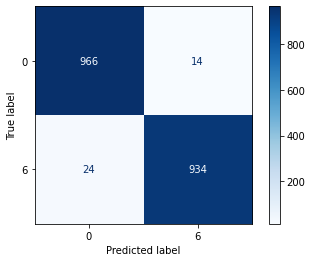


Label totals in dataset:
 [(0, 980), (6, 958)]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix_bin = confusion_matrix(Y_test_bin, Y_pred_bin)
ConfusionMatrixDisplay(matrix_bin, [0,6]).plot(cmap="Blues", values_format='')
plt.show()
print("\nLabel totals in dataset:\n", list(zip([0, 6], np.sum(matrix_bin, axis=-1))))

Looks great! We further can improve the results by increasing the number of epochs, changing the hidden layer format and other hyperparameters. This process is called hyperparameter tuning, which you can do manually by trial and error or by using some available tools. We can also adapt learning rate scheduling methods.

Now let's head towards the multiclass classification problem.

<br><br><br><br>

###**Multi-class Classification problem:**
We will do the same thing, with multiple classes this time. We will consider the digits **'1', '5', '7',** and **'9'**.

In [ ]:
train_idx = np.where((Y_train==1) | (Y_train==5) | (Y_train==7) | (Y_train==9))
X_train_multiclass = X_normalized_train[train_idx]
Y_train_multiclass = Y_train[train_idx]

test_idx = np.where((Y_test==1) | (Y_test==5) | (Y_test==7) | (Y_test==9))
X_test_multiclass = X_normalized_test[test_idx]
Y_test_multiclass = Y_test[test_idx]

print(f'Trainset shapes - X: {X_train_multiclass.shape}, Y: {Y_train_multiclass.shape}')
print(f'Testset shapes - X: {X_test_multiclass.shape}, Y: {Y_test_multiclass.shape}')

print(f'\nTrain statistics - 1: {(Y_train_multiclass==1).sum()}, 5: {(Y_train_multiclass==5).sum()}, 7: {(Y_train_multiclass==7).sum()}, 9: {(Y_train_multiclass==9).sum()}')
print(f'Test statistics - 1: {(Y_test_multiclass==1).sum()}, 5: {(Y_test_multiclass==5).sum()}, 7: {(Y_test_multiclass==7).sum()}, 9: {(Y_test_multiclass==9).sum()}')

Trainset shapes - X: (24377, 784), Y: (24377,)
Testset shapes - X: (4064, 784), Y: (4064,)

Train statistics - 1: 6742, 5: 5421, 7: 6265, 9: 5949
Test statistics - 1: 1135, 5: 892, 7: 1028, 9: 1009


In [ ]:
# Setting label correct labels for multi class classification

Y_train_multiclass[Y_train_multiclass==1] = 0 
Y_test_multiclass[Y_test_multiclass==1] = 0 

Y_train_multiclass[Y_train_multiclass==5] = 1 
Y_test_multiclass[Y_test_multiclass==5] = 1 

Y_train_multiclass[Y_train_multiclass==7] = 2 
Y_test_multiclass[Y_test_multiclass==7] = 2 

Y_train_multiclass[Y_train_multiclass==9] = 3 
Y_test_multiclass[Y_test_multiclass==9] = 3 

In [ ]:
X_train_multiclass, X_val_multiclass, Y_train_multiclass, Y_val_multiclass = train_test_split(X_train_multiclass, Y_train_multiclass, test_size=0.2, random_state = 1)

In [ ]:
print(f'Trainset shapes - X: {X_train_multiclass.shape}, Y: {Y_train_multiclass.shape}')
print(f'Valset shapes - X: {X_val_multiclass.shape}, Y: {Y_val_multiclass.shape}')

print(f'\nTrain statistics - 1: {(Y_train_multiclass==0).sum()}, 5: {(Y_train_multiclass==1).sum()}, 7: {(Y_train_multiclass==2).sum()}, 9: {(Y_train_multiclass==3).sum()}')
print(f'Val statistics - 1: {(Y_val_multiclass==0).sum()}, 5: {(Y_val_multiclass==1).sum()}, 7: {(Y_val_multiclass==2).sum()}, 9: {(Y_val_multiclass==3).sum()}')

Trainset shapes - X: (19501, 784), Y: (19501,)
Valset shapes - X: (4876, 784), Y: (4876,)

Train statistics - 1: 5353, 5: 4384, 7: 5002, 9: 4762
Val statistics - 1: 1389, 5: 1037, 7: 1263, 9: 1187


In [ ]:
# Traspose feature matrices as per our model requirement

X_train_multiclass, X_val_multiclass, X_test_multiclass = X_train_multiclass.T, X_val_multiclass.T, X_test_multiclass.T
print(f'Shapes - {X_train_multiclass.shape, X_val_multiclass.shape, X_test_multiclass.shape}')

Shapes - ((784, 19501), (784, 4876), (784, 4064))


Epoch 5..............Loss on train = 0.19872723105389653, Loss on val = 0.2586517458101861
Epoch 10..............Loss on train = 0.14157001945268868, Loss on val = 0.2081694474407669
Epoch 15..............Loss on train = 0.11244442914029225, Loss on val = 0.18834962853430576
Epoch 20..............Loss on train = 0.09464269015400432, Loss on val = 0.17738348893405562
Epoch 25..............Loss on train = 0.08125909045320052, Loss on val = 0.16742972181942098
Epoch 30..............Loss on train = 0.07278057628506081, Loss on val = 0.16460035991492197
Epoch 35..............Loss on train = 0.06320198523634658, Loss on val = 0.15537610965656218
Epoch 40..............Loss on train = 0.05693379479746201, Loss on val = 0.15438683800232972
Epoch 45..............Loss on train = 0.05071865271918986, Loss on val = 0.14908594305474077
Epoch 50..............Loss on train = 0.04580163466924893, Loss on val = 0.14618085126558603
Epoch 55..............Loss on train = 0.041814124240274385, Loss on val =

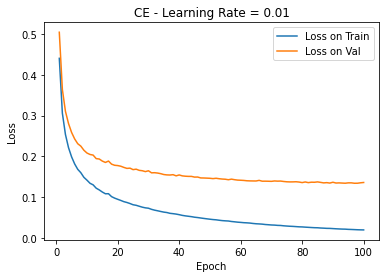

In [ ]:
# Creating model instance

D_in, H1, H2, D_out = 784, 200, 100, 4 # As there are 4 classes
neurons = [D_in, H1, H2, D_out]
activation_functions = ['sigmoid','sigmoid','softmax'] # activations in each layer (Note: the input layer does not have any activation)
nn_multiclass = Neural_Network(neurons, activation_functions)
losses = nn_multiclass.train(X_train_multiclass, Y_train_multiclass, batch_size=10, lr=1e-2, max_epochs=100, n_classes = 4,
                             onehotencoded=True, loss_func='CE', Xval = X_val_multiclass, Yval = Y_val_multiclass)

In [ ]:
# checking first 10 predictions

print("First 10 outputs:", Y_test_multiclass[:10])
preds = nn_multiclass.predict(X_test_multiclass[:, :10])
print("First 10 predictions:", preds)

First 10 outputs: [2 0 0 3 1 3 3 0 1 3]
First 10 predictions: [2 0 0 3 1 3 3 0 1 3]


##Model accuracy:


In [ ]:
Y_pred_multiclass = nn_multiclass.predict(X_test_multiclass)
multiclass_score = (Y_pred_multiclass == Y_test_multiclass).mean()
print("Model accuracy =", round(multiclass_score*100,2),"%")

Model accuracy = 96.85 %


##Confusion matrix:

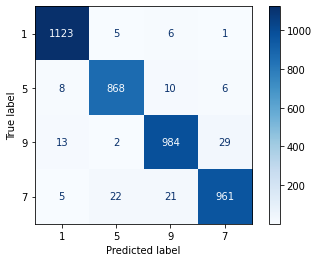


Label totals in dataset:
 [(1, 1135), (5, 892), (9, 1028), (7, 1009)]


In [ ]:
matrix_multiclass = confusion_matrix(Y_test_multiclass, Y_pred_multiclass)
ConfusionMatrixDisplay(matrix_multiclass, [1,5,9,7]).plot(cmap="Blues", values_format='')
plt.show()
print("\nLabel totals in dataset:\n", list(zip([1,5,9,7], np.sum(matrix_multiclass, axis=-1))))

<br> <br> <br> <br> 

### Learning Rate Schedulers

In [ ]:
# Example schedulers

def s1(epoch):
    return 1/(epoch+1)

def timebased(epoch, initial_lr=0.1, decay=0.1):
    return initial_lr/(1+decay*epoch)

def dropbased(epoch, initial_lr=0.1, epoch_drop=10, drop_rate=0.5):
    return initial_lr* drop_rate**(epoch//epoch_drop)
    
def exponential(epoch, initial_lr=0.1, k=0.1):
    return initial_lr*np.exp(-k*epoch)

example_schedulers = {'s1': s1, 'timebased': timebased, 'dropbased': dropbased, 'exponential': exponential}

# example_schedulers = {
#     's1': lambda epoch: (1/(epoch+1)),
#     'timebased': lambda epoch, initial_lr=0.1, decay=0.1: (initial_lr/(1+decay*epoch)),
#     'dropbased': lambda epoch, initial_lr=0.1, epoch_drop=10, drop_rate=0.5: (initial_lr* drop_rate**(epoch//epoch_drop)),
#     'exponential': lambda epoch, initial_lr=0.1, k=0.1: (initial_lr*np.exp(-k*epoch)),
# }

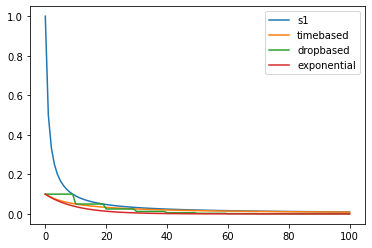

In [ ]:
for k, schedule in example_schedulers.items():
  x = np.arange(0, 101)
  y = np.vectorize(schedule)(x)
  plt.plot(x, y, label=k)

plt.legend()
plt.show()

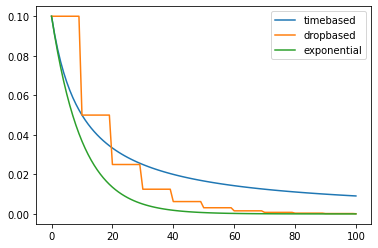

In [ ]:
# Just last three

for k, schedule in list(example_schedulers.items())[1:]:
  x = np.arange(0, 101)
  y = np.vectorize(schedule)(x)
  plt.plot(x, y, label=k)

plt.legend()
plt.show()

In [ ]:
for k, schedule in example_schedulers.items():
  print(f'Scheduler {k}: lr = {get_lr(schedule)(5)} for 5th epoch')

0.001
Scheduler s1: lr = 0.16666666666666666 for 5th epoch
Scheduler timebased: lr = 0.06666666666666667 for 5th epoch
Scheduler dropbased: lr = 0.1 for 5th epoch
Scheduler exponential: lr = 0.06065306597126335 for 5th epoch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


Epoch 5..............Loss on train = 0.010471404085629906, Loss on val = 0.010758421895397318
Epoch 10..............Loss on train = 0.008715380419610647, Loss on val = 0.009341234274035451
Epoch 15..............Loss on train = 0.010346272563243374, Loss on val = 0.010764035457756468
Epoch 20..............Loss on train = 0.009592870529917646, Loss on val = 0.010964631612692477
Epoch 25..............Loss on train = 0.007273586169794938, Loss on val = 0.006119583181806939
Epoch 30..............Loss on train = 0.006492821147202858, Loss on val = 0.007814559237052739
Early Stopping .............. Returning best weights


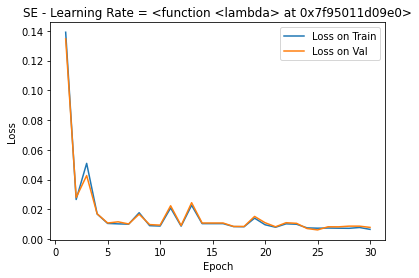

In [ ]:
D_in, H1, H2, D_out = 784, 200, 100, 1 #You can add more layers or more outputs if you wish. 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['relu','relu','sigmoid'] # activations in each layer (Note: the input layer does not have any activation)
nn_bin2 = Neural_Network(neurons, activation_functions) # There we go, creating our neural network.
losses = nn_bin2.train(X_train_bin, Y_train_bin, batch_size=10, lr=example_schedulers['timebased'],
                      max_epochs=50, Xval = X_val_bin, Yval = Y_val_bin)

In [ ]:
# Testing

Y_pred_bin2 = nn_bin2.predict(X_test_bin)
bin2_score = (Y_pred_bin2 == Y_test_bin).mean()
print("Model accuracy =", round(bin2_score*100,2),"%")

Model accuracy = 98.4 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
